In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
#from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
#from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, f1_score, log_loss
from sklearn.metrics import classification_report,confusion_matrix, precision_recall_fscore_support 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import  svm
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt


%matplotlib inline

In [2]:
df = pd.read_csv('kidney_disease.csv')

In [3]:
#cleaning of data for garbage values
df = df.replace("?", np.nan)
df = df.replace("	?", np.nan)
df['htn'] = df['htn'].replace(to_replace={'\tno':'no','\tyes':'yes',' yes':'yes', '':np.nan})
df[['appet']] = df[['appet']].replace(to_replace={'no':np.nan})
df['dm'] = df['dm'].replace(to_replace={'\tno':'no','\tyes':'yes',' yes':'yes', '':np.nan})
df['classification'] = df['classification'].replace(to_replace={'ckd\t':'ckd'})
df['cad'] = df['cad'].replace(to_replace='\tno',value='no')

print(df.head())

#using techniques like mean and mode to fill the missing values
for column in df.columns:
    if df[column].dtype == np.number:
        #filled the missing values of numeric dataset with the mean of the column
        df[column].fillna(df[column].mean(), inplace=True)
    else:
        #filled the missing values of string dataset with the mode of the column
        df[column].fillna(df[column].value_counts().idxmax(), inplace=True)
        #converting the string values into categorical values for evaluation through different models
        if(column == "dm"):
            df[column] = LabelEncoder().fit_transform(df[column])
        else:
            df[column] = LabelEncoder().fit_transform(df[column])
#renaming column classification to class
df.rename(columns = {'classification':'class'},inplace = True)
#removing the column id as it has no actual use in my project and is an extra column
df.drop('id',axis=1,inplace=True)
print(df.head())
#furter cleaning of dataframe if any more NAN values are left
df = df.dropna(axis=0)
#gives the count of uniques values in the column class
df['htn'].value_counts()

   id   age    bp     sg   al   su    bgr    bu   sc    sod  ...   dm  cad  \
0   0  48.0  80.0  1.020  1.0  0.0  121.0  36.0  1.2    NaN  ...  yes   no   
1   1   7.0  50.0  1.020  4.0  0.0    NaN  18.0  0.8    NaN  ...   no   no   
2   2  62.0  80.0  1.010  2.0  3.0  423.0  53.0  1.8    NaN  ...  yes   no   
3   3  48.0  70.0  1.005  4.0  0.0  117.0  56.0  3.8  111.0  ...   no   no   
4   4  51.0  80.0  1.010  2.0  0.0  106.0  26.0  1.4    NaN  ...   no   no   

   appet   pe     rbc        pc         pcc          ba  ane classification  
0   good   no     NaN    normal  notpresent  notpresent   no            ckd  
1   good   no     NaN    normal  notpresent  notpresent   no            ckd  
2   poor   no  normal    normal  notpresent  notpresent  yes            ckd  
3   poor  yes  normal  abnormal     present  notpresent  yes            ckd  
4   good   no  normal    normal  notpresent  notpresent   no            ckd  

[5 rows x 26 columns]
    age    bp     sg   al   su         b

0    253
1    147
Name: htn, dtype: int64

In [4]:
X = df.iloc[:,0:24]
#y is THE CLASSIFICATION COLUMN IT WILL BE USED LATER IN THE TEST_tRAIN_SPLIT
y = df.iloc[:,-1] 

In [5]:
#these lines of code are used for feature scaling using normalization. Faaiz will work on other similar methods and come up with the best, for the time being we can use this method.
x_scaler = MinMaxScaler()
x_scaler.fit(X)
column_names = X.columns
X[column_names] = x_scaler.transform(X)
print(X.head())

        age        bp    sg   al   su       bgr        bu        sc       sod  \
0  0.522727  0.230769  0.75  0.2  0.0  0.211538  0.088575  0.010582  0.839298   
1  0.056818  0.000000  0.75  0.8  0.0  0.269309  0.042362  0.005291  0.839298   
2  0.681818  0.230769  0.25  0.4  0.6  0.856838  0.132221  0.018519  0.839298   
3  0.522727  0.153846  0.00  0.8  0.0  0.202991  0.139923  0.044974  0.671924   
4  0.556818  0.230769  0.25  0.4  0.0  0.179487  0.062901  0.013228  0.839298   

        pot  ...  htn   dm  cad  appet   pe  rbc   pc  pcc   ba  ane  
0  0.047803  ...  1.0  1.0  0.0    0.0  0.0  1.0  1.0  0.0  0.0  0.0  
1  0.047803  ...  0.0  0.0  0.0    0.0  0.0  1.0  1.0  0.0  0.0  0.0  
2  0.047803  ...  0.0  1.0  0.0    1.0  0.0  1.0  1.0  0.0  0.0  1.0  
3  0.000000  ...  1.0  0.0  0.0    1.0  1.0  1.0  0.0  1.0  0.0  1.0  
4  0.047803  ...  0.0  0.0  0.0    0.0  0.0  1.0  1.0  0.0  0.0  0.0  

[5 rows x 24 columns]


[0.00730525 0.012611   0.1583048  0.1137343  0.01571984 0.01865043
 0.01158973 0.01637316 0.01016217 0.00462588 0.1216478  0.08883529
 0.00618041 0.04480773 0.11444539 0.11038995 0.00201932 0.04503257
 0.02968238 0.01700021 0.02859081 0.00690353 0.00157417 0.01381389]


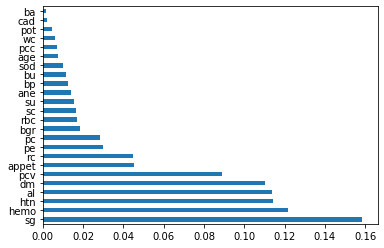

Index(['sg', 'hemo', 'htn', 'al', 'dm', 'pcv'], dtype='object')


In [6]:
#the below code is used to find the best attributes out of the 24.
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) 
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
#THIS LINE I HAVE STORED THE TOP 18 VALUES INTO x SO WHENEVR YOU WANT TO CHANGE THE NUMBER OF ATTRIBUTES AND TEST JUST CHANGE THE NUMBER
x = feat_importances.nlargest(6).keys()
feat_importances.nlargest(25).plot(kind='barh')
plt.show()
print (x)

In [7]:
#I HAVE DROPPED THE OTHER COLUMN WHICH WHERE NOT REQUIRED. IF THE VALUE OF x WILL BE 24 THAN ALL THE COLUMN WILL BE INCLUDED
X = X.drop([col for col in X.columns if not col in x ], axis=1)
X.head()

,sg,al,hemo,pcv,htn,dm
0,0.75,0.2,0.836735,0.777778,1.0,1.0
1,0.75,0.8,0.557823,0.644444,0.0,0.0
2,0.25,0.4,0.442177,0.488889,0.0,1.0
3,0.00,0.8,0.551020,0.511111,1.0,0.0
4,0.25,0.4,0.578231,0.577778,0.0,0.0


In [8]:
#used for spliting dataset into test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
classifiers = [
    KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2),
    #SVC(C=.1, degree=1, kernel='poly', probability=True),
    #NuSVC(nu=.1, degree=1, kernel='poly', probability=True),
    DecisionTreeClassifier(),
    #AdaBoostClassifier(),
    #GradientBoostingClassifier(),
    GaussianNB(),
    #LinearDiscriminantAnalysis(),
    LogisticRegression()]

# Logging for Visual Comparison
log_cols = ["Classifier", "Accuracy", "f1score", "specificity", "sensitivity", 'Log Loss']
log = pd.DataFrame(columns=log_cols)

for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print("="*30)
    print(name)
    try:
        print('****Results****')
        train_predictions = clf.predict(X_test)
        acc = accuracy_score(y_test, train_predictions)
        print("Accuracy: {:.4%}".format(acc))
        pre_score = precision_score(y_test, train_predictions)
        print("precision score: \n {:.4}".format(pre_score))
        f1score = f1_score(y_test, train_predictions)
        print("f1_score: \n {:.4}".format(f1score))
        # print("classification_report: \n",classification_report(y_test, train_predictions))
        conmat = confusion_matrix(y_test, train_predictions)
        print("confusion_matrix: \n",conmat)        
        tn, fp, fn, tp = conmat.ravel()
        specificity = (tn)/(tn + fp)
        print("Specificity: \n {:.4}".format(specificity))
        sensitivity = (tp)/(tp + fn)
        print("Sensitivity: \n {:.4}".format(sensitivity))
        print("log_loss: \n",log_loss(y_test, train_predictions))
        log_entry = pd.DataFrame([[name, acc*100,f1score, specificity, sensitivity, log_loss(y_test, train_predictions)]], columns=log_cols)
        log = log.append(log_entry)
    except Exception as e:
        print (e)
    
print("="*30)

KNeighborsClassifier
****Results****
Accuracy: 97.5000%
precision score: 
 0.9643
f1_score: 
 0.9643
confusion_matrix: 
 [[51  1]
 [ 1 27]]
Specificity: 
 0.9808
Sensitivity: 
 0.9643
log_loss: 
 0.8634794048406453
DecisionTreeClassifier
****Results****
Accuracy: 98.7500%
precision score: 
 0.9655
f1_score: 
 0.9825
confusion_matrix: 
 [[51  1]
 [ 0 28]]
Specificity: 
 0.9808
Sensitivity: 
 1.0
log_loss: 
 0.4317446999042619
GaussianNB
****Results****
Accuracy: 96.2500%
precision score: 
 0.9032
f1_score: 
 0.9492
confusion_matrix: 
 [[49  3]
 [ 0 28]]
Specificity: 
 0.9423
Sensitivity: 
 1.0
log_loss: 
 1.2952340997127838
LogisticRegression
****Results****
Accuracy: 98.7500%
precision score: 
 0.9655
f1_score: 
 0.9825
confusion_matrix: 
 [[51  1]
 [ 0 28]]
Specificity: 
 0.9808
Sensitivity: 
 1.0
log_loss: 
 0.4317446999042619


In [10]:
# ANN

In [11]:
from keras.models import Sequential  #to initialize the neural network
from keras.layers import Dense  # to build the layers of ANN
from keras.layers import Dropout
from keras.optimizers import SGD


Using TensorFlow backend.
C:\Users\Abhimanyu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Abhimanyu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Abhimanyu\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Abhimanyu\anaconda3\lib\site-packages\tensorflow\python\fra

In [12]:
f = int((len(X.columns)+1)/2)
import warnings
import keras as k
warnings.filterwarnings('ignore')
# Initialising the ANN
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = f,  kernel_initializer = 'uniform', activation = 'relu', input_dim = len(X.columns)))
#classifier.add(Dropout(0.2))
# Adding the second hidden layer
classifier.add(Dense(units = f, kernel_initializer ='uniform', activation = 'relu'))
classifier.add(Dropout(0.2))
# Adding the output layer
classifier.add(Dense(units=1, kernel_initializer = 'uniform', activation = 'hard_sigmoid'))
# Compiling the ANN
#sgd = SGD(lr=0.0001, decay=0.01, momentum=0.9, nesterov=True)
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
# Fitting the ANN to the Training set
model = classifier.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 5, epochs = 200)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 320 samples, validate on 80 samples
Epoch 1/200
320/320 [==============================] - 1s 3ms/step - loss: 0.6922 - accuracy: 0.6094 - val_loss: 0.6901 - val_accuracy: 0.6500
Epoch 2/200
320/320 [==============================] - 0s 346us/step - loss: 0.6898 - accuracy: 0.6187 - val_loss: 0.6873 - val_accuracy: 0.6500
Epoch 3/200
320/320 [==============================] - 0s 305us/step - loss: 0.6876 - accuracy: 0.6187 - val_loss: 0.6846 - val_accuracy: 0.6500
Epoch 4/200
320/320 [==============================] - 0s 533us/step - loss: 0.6855 - accuracy: 0.6187 - val_loss: 0.6821 - val_accuracy: 0.6500
Epoch 5/200
320/320 [==============================] - 0s 415us/step - loss: 0.6836 - accuracy: 0.6187 - val_loss: 0.6795 - val_accuracy: 0.6500
Epoch 6/200
320/320 [==============================] - 0s 371us/step - loss: 0.6819 - accuracy: 0.6187 - val_loss: 0.6773 - val_accuracy:

320/320 [==============================] - 0s 281us/step - loss: 0.6649 - accuracy: 0.6187 - val_loss: 0.6505 - val_accuracy: 0.6500
Epoch 54/200
320/320 [==============================] - 0s 299us/step - loss: 0.6649 - accuracy: 0.6187 - val_loss: 0.6502 - val_accuracy: 0.6500
Epoch 55/200
320/320 [==============================] - 0s 266us/step - loss: 0.6649 - accuracy: 0.6187 - val_loss: 0.6504 - val_accuracy: 0.6500
Epoch 56/200
320/320 [==============================] - 0s 281us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6503 - val_accuracy: 0.6500
Epoch 57/200
320/320 [==============================] - 0s 307us/step - loss: 0.6649 - accuracy: 0.6187 - val_loss: 0.6503 - val_accuracy: 0.6500
Epoch 58/200
320/320 [==============================] - 0s 287us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6501 - val_accuracy: 0.6500
Epoch 59/200
320/320 [==============================] - 0s 324us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6501 - val_accuracy

320/320 [==============================] - 0s 312us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 110/200
320/320 [==============================] - 0s 296us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 111/200
320/320 [==============================] - 0s 327us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 112/200
320/320 [==============================] - 0s 321us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 113/200
320/320 [==============================] - 0s 318us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 114/200
320/320 [==============================] - 0s 274us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 115/200
320/320 [==============================] - 0s 290us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6495 - val_ac

Epoch 165/200
320/320 [==============================] - 0s 287us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 166/200
320/320 [==============================] - 0s 293us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 167/200
320/320 [==============================] - 0s 280us/step - loss: 0.6647 - accuracy: 0.6187 - val_loss: 0.6496 - val_accuracy: 0.6500
Epoch 168/200
320/320 [==============================] - 0s 249us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 169/200
320/320 [==============================] - 0s 277us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6495 - val_accuracy: 0.6500
Epoch 170/200
320/320 [==============================] - 0s 256us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0.6494 - val_accuracy: 0.6500
Epoch 171/200
320/320 [==============================] - 0s 287us/step - loss: 0.6648 - accuracy: 0.6187 - val_loss: 0

In [13]:
print('****Results****')
train_predictions = classifier.predict(X_test)
train_predictions = (train_predictions > 0.8)
acc = accuracy_score(y_test, train_predictions)
print("Accuracy: {:.4%}".format(acc))
pre_score = precision_score(y_test, train_predictions)
print("precision score: \n {:.4}".format(pre_score))
f1score = f1_score(y_test, train_predictions)
print("f1_score: \n {:.4}".format(f1score))
conmat = confusion_matrix(y_test, train_predictions)
print("confusion_matrix: \n",conmat)        
tn, fp, fn, tp = conmat.ravel()
specificity = (tn)/(tn+fp)
print("Specificity: \n {:.4}".format(specificity))
sensitivity = (tp)/(tp + fn)
print("Sensitivity: \n {:.4}".format(sensitivity))
print("log_loss: \n",log_loss(y_test, train_predictions))


****Results****
Accuracy: 65.0000%
precision score: 
 0.0
f1_score: 
 0.0
confusion_matrix: 
 [[52  0]
 [28  0]]
Specificity: 
 1.0
Sensitivity: 
 0.0
log_loss: 
 12.08857173821874


In [14]:
log_entry = pd.DataFrame([['ANN', acc*100,pre_score, specificity, sensitivity, log_loss(y_test, train_predictions)]], columns=log_cols)
log = log.append(log_entry)

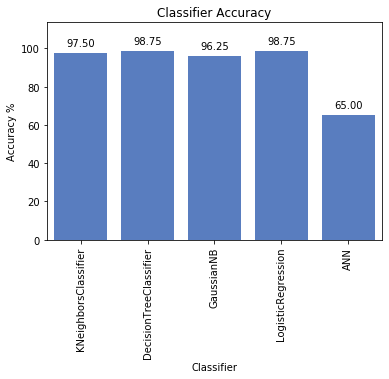

In [15]:
sns.set_color_codes("muted")
bars = sns.barplot(x='Classifier', y='Accuracy', data=log, color="b", ci = None)
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Accuracy %')
plt.xticks(rotation = 90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 10))
plt.title('Classifier Accuracy')
plt.show()

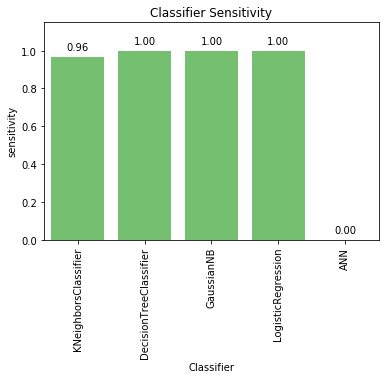

In [16]:
sns.set_color_codes("muted")
bars = sns.barplot(x='Classifier', y='sensitivity', data=log, color="g", ci = None)
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation = 90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 0.1))
plt.xticks(rotation = 90)
plt.ylabel('sensitivity')
plt.title('Classifier Sensitivity')
plt.show()

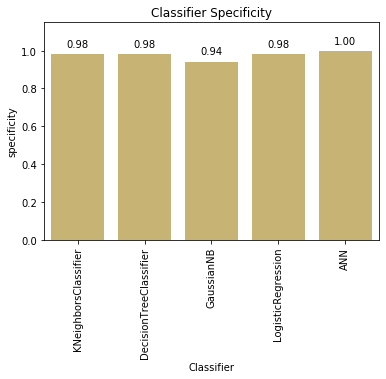

In [17]:
sns.set_color_codes("muted")
bars = sns.barplot(x='Classifier', y='specificity', data=log, color="y", ci = None)
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('Accuracy %')
plt.xticks(rotation = 90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 0.1))
plt.xticks(rotation = 90)
plt.ylabel('specificity')
plt.title('Classifier Specificity')
plt.show()

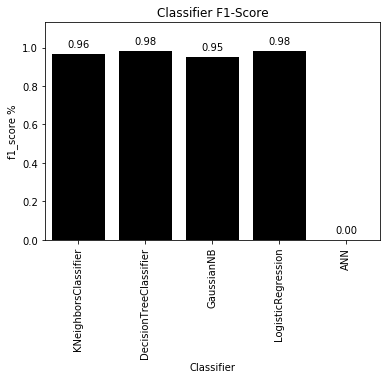

In [18]:
sns.set_color_codes("muted")
bars = sns.barplot(x='Classifier', y='f1score', data=log, color="black", ci = None)
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.ylabel('f1_score %')
plt.xticks(rotation = 90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 0.1))
plt.xticks(rotation = 90)
plt.title('Classifier F1-Score')
plt.show()

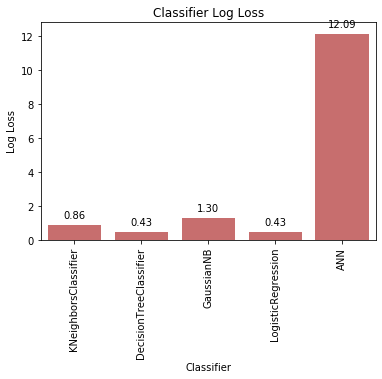

In [19]:
sns.set_color_codes("muted")
bars = sns.barplot(x='Classifier', y='Log Loss', data=log, color="r", ci = None)
for p in bars.patches:
    bars.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.xticks(rotation = 90)
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,y1,y2 + 0.1))
plt.xticks(rotation = 90)
plt.ylabel('Log Loss')
plt.title('Classifier Log Loss')
plt.show()

# Thank You